<a href="https://colab.research.google.com/github/isabellacadisco/Human_Value_Detection_P2/blob/main/tests/P2_Bert_Premise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 

In [2]:

# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

# for viz
import matplotlib.pyplot as plt

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()
import copy


In [3]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
# train
arg_training = pd.read_csv("arguments-training.tsv", delimiter='\t')
label_training = pd.read_csv("labels-training.tsv", delimiter= '\t')
df_training = pd.merge(arg_training, label_training, how='left', on="Argument ID")

In [6]:
# validation
arg_validation = pd.read_csv("arguments-validation.tsv", delimiter='\t')
label_validation = pd.read_csv("labels-validation.tsv", delimiter= '\t')
df_validation = pd.merge(arg_validation, label_validation, how='left', on="Argument ID")

In [7]:
# test
arg_test = pd.read_csv("arguments-test.tsv", delimiter='\t')
label_test = pd.read_csv("labels-test.tsv", delimiter= '\t')
df_test = pd.merge(arg_test, label_test, how='left', on="Argument ID")

In [8]:
selected_col = ['Argument ID', 'Conclusion', 'Stance', 'Premise','Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern']

subset_train = df_training[selected_col]
subset_val = df_validation[selected_col]
subset_test = df_test[selected_col]


In [9]:
subset_train['list'] = subset_train[subset_train.columns[4:]].values.tolist()
train_set = subset_train[['Premise', 'list']].copy()
train_set.head()

<ipython-input-9-f3255add7ac2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train['list'] = subset_train[subset_train.columns[4:]].values.tolist()


,Premise,list
0,we should ban human cloning as it will only ca...,"[0, 0, 0, 1, 0, 0]"
1,fast food should be banned because it is reall...,"[0, 0, 1, 0, 0, 0]"
2,sometimes economic sanctions are the only thin...,"[0, 0, 0, 1, 0, 0]"
3,capital punishment is sometimes the only optio...,"[0, 0, 0, 1, 0, 1]"
4,factory farming allows for the production of c...,"[0, 0, 1, 0, 1, 1]"


In [10]:
subset_val['list'] = subset_val[subset_val.columns[4:]].values.tolist()
val_set = subset_val[['Premise', 'list']].copy()
val_set.head()

<ipython-input-10-deca4c8a7bc4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_val['list'] = subset_val[subset_val.columns[4:]].values.tolist()


,Premise,list
0,if entrapment can serve to more easily capture...,"[0, 0, 0, 1, 0, 0]"
1,the use of public defenders should be mandator...,"[0, 0, 0, 0, 0, 1]"
2,payday loans create a more impoverished societ...,"[0, 0, 1, 0, 0, 1]"
3,Surrogacy should not be banned as it is the wo...,"[1, 0, 0, 0, 0, 0]"
4,entrapment is gravely immoral and against huma...,"[0, 0, 0, 0, 0, 1]"


In [11]:
subset_test['list'] = subset_test[subset_test.columns[4:]].values.tolist()
test_set = subset_test[['Premise', 'list']].copy()
test_set.head()

<ipython-input-11-6a30c75f902a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test['list'] = subset_test[subset_test.columns[4:]].values.tolist()


,Premise,list
0,affirmative action helps with employment equity.,"[0, 1, 1, 0, 0, 1]"
1,affirmative action can be considered discrimin...,"[0, 1, 0, 0, 0, 1]"
2,naturopathy is very dangerous for the most vul...,"[0, 1, 1, 0, 0, 1]"
3,women shouldn't be in combat because they aren...,"[0, 1, 0, 0, 0, 0]"
4,once eradicated illnesses are returning due to...,"[0, 1, 1, 1, 1, 0]"


In [12]:
# variables that will be used later on in the training
MAX_LEN = 189
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 2e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.Premise = dataframe.Premise
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.Premise)

    def __getitem__(self, index):
        Premise = str(self.Premise[index])
        Premise = " ".join(Premise.split())

        inputs = self.tokenizer.encode_plus(
            Premise,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            #pad_to_max_length=True, deprecated
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [14]:
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print("TRAIN Dataset: {}".format(train_set.shape))
print("TEST Dataset: {}".format(test_set.shape))

TRAIN Dataset: (5393, 2)
TEST Dataset: (1576, 2)


In [15]:
training_set = CustomDataset(train_set, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_set, tokenizer, MAX_LEN)

In [16]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [17]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3) # aumento drop out
        self.l3 = torch.nn.Linear(768, 6)

    def forward(self, ids, mask, token_type_ids):

        outputs = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output_1 = outputs.pooler_output #!!!

        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [18]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [19]:
# optimizer and LR scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)  #weight decay


In [20]:
def train(epoch):
    model.train()

    losses = []

    t_fin_targets=[]
    t_fin_outputs=[]

    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids)

        t_fin_targets.extend(targets.cpu().detach().numpy().tolist())
        # apply SIGMOID to get multilabel predictions
        t_fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        #optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        #if _%2000==0:
         #   print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        # backward
        optimizer.zero_grad()
        loss.backward()
        # clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    return t_fin_outputs, t_fin_targets, np.mean(losses)

In [21]:
def validation(epoch):
    model.eval()

    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad(): #disable gradient calculation, useful for evaluation
        for _, data in enumerate(testing_loader, 0):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [22]:
metrics_train_eval = {}

In [23]:
for epoch in range(EPOCHS):

    print(f'Epoch: {epoch}')

    # training ----------------------------------------------------------------
    train_outputs, train_targets, train_loss = train(epoch)
    # put to 1 predictions with value >= 0.5
    train_outputs = np.array(train_outputs) >= 0.5

    train_accuracy = metrics.accuracy_score(train_targets, train_outputs)
    train_f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
    train_f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')
    train_hamming_loss = metrics.hamming_loss(train_targets, train_outputs)

    metrics_train_eval[epoch] = {'Train Accuracy Score' : train_accuracy,
                        'Train F1 Score (Micro)' : train_f1_score_micro,
                        'Train F1 Score (Macro)' : train_f1_score_macro,
                        'Train Hamming Loss' : train_hamming_loss}

    print(f"Train Accuracy Score = {train_accuracy}")
    print(f"Train F1 Score (Micro) = {train_f1_score_micro}")
    print(f"Train F1 Score (Macro) = {train_f1_score_macro}")
    print(f"Train Hamming Loss = {train_hamming_loss}")
    print(f"Train Loss = {train_loss}")


    # validation --------------------------------------------------------------

    eval_outputs, eval_targets = validation(epoch)
    # put to 1 predictions with value >= 0.5
    eval_outputs = np.array(eval_outputs) >= 0.5

    eval_accuracy = metrics.accuracy_score(eval_targets, eval_outputs)
    eval_f1_score_micro = metrics.f1_score(eval_targets, eval_outputs, average='micro')
    eval_f1_score_macro = metrics.f1_score(eval_targets, eval_outputs, average='macro')
    eval_hamming_loss = metrics.hamming_loss(eval_targets, eval_outputs)

    metrics_train_eval[epoch].update({
        'Eval Accuracy Score': eval_accuracy,
        'Eval F1 Score (Micro)': eval_f1_score_micro,
        'Eval F1 Score (Macro)': eval_f1_score_macro,
        'Eval Hamming Loss' : eval_hamming_loss
    })

    print(f"Eval Accuracy Score = {eval_accuracy}")
    print(f"Eval F1 Score (Micro) = {eval_f1_score_micro}")
    print(f"Eval F1 Score (Macro) = {eval_f1_score_macro}")
    print(f"Eval Hamming Loss = {eval_hamming_loss}")

    print('-------------------------------------------------------------------')


Epoch: 0
Train Accuracy Score = 0.13944001483404414
Train F1 Score (Micro) = 0.3446193659693767
Train F1 Score (Macro) = 0.30532997770575016
Train Hamming Loss = 0.28175412571852404
Train Loss = 0.568096359805948
Eval Accuracy Score = 0.23413705583756345
Eval F1 Score (Micro) = 0.5369039843239712
Eval F1 Score (Macro) = 0.44175369372936935
Eval Hamming Loss = 0.22493654822335024
-------------------------------------------------------------------


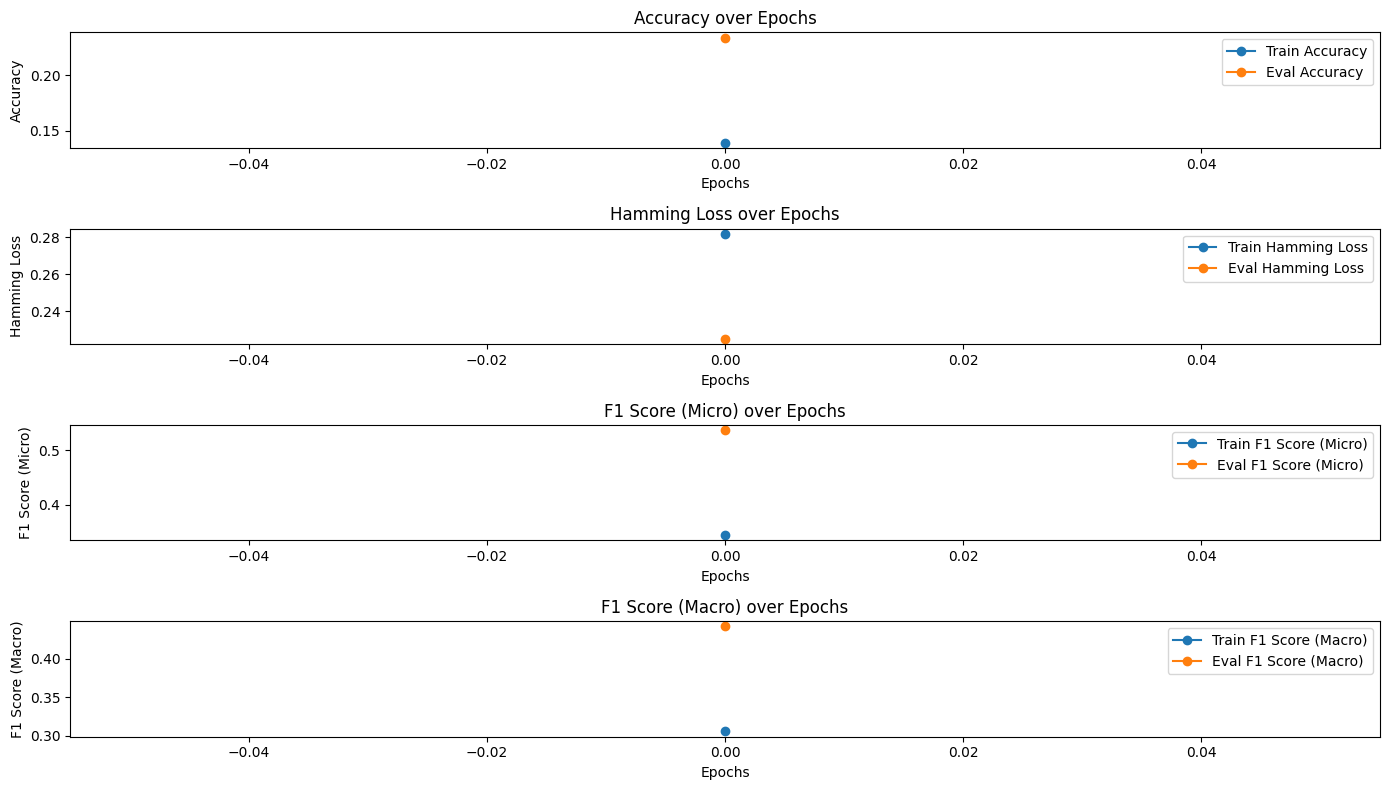

In [24]:
# extract metrics
epochs = list(metrics_train_eval.keys())

train_accuracy = [metrics_train_eval[epoch]['Train Accuracy Score'] for epoch in epochs]
eval_accuracy = [metrics_train_eval[epoch]['Eval Accuracy Score'] for epoch in epochs]

train_f1_micro = [metrics_train_eval[epoch]['Train F1 Score (Micro)'] for epoch in epochs]
eval_f1_micro = [metrics_train_eval[epoch]['Eval F1 Score (Micro)'] for epoch in
epochs]

train_f1_macro = [metrics_train_eval[epoch]['Train F1 Score (Macro)'] for epoch in epochs]
eval_f1_macro = [metrics_train_eval[epoch]['Eval F1 Score (Macro)'] for epoch in epochs]

train_h_loss = [metrics_train_eval[epoch]['Train Hamming Loss'] for epoch in epochs]
eval_h_loss = [metrics_train_eval[epoch]['Eval Hamming Loss'] for epoch in epochs]

# plot fig
plt.figure(figsize=(14, 8))

# accuracy plot
plt.subplot(4, 1, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, eval_accuracy, label='Eval Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# hamming loss plot
plt.subplot(4, 1, 2)
plt.plot(epochs, train_h_loss, label='Train Hamming Loss', marker='o')
plt.plot(epochs, eval_h_loss, label='Eval Hamming Loss', marker='o')
plt.title('Hamming Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Hamming Loss')
plt.legend()

# F1 micro plot
plt.subplot(4, 1, 3)
plt.plot(epochs, train_f1_micro, label='Train F1 Score (Micro)', marker='o')
plt.plot(epochs, eval_f1_micro, label='Eval F1 Score (Micro)', marker='o')
plt.title('F1 Score (Micro) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Micro)')
plt.legend()

# F1 macro plot
plt.subplot(4, 1, 4)
plt.plot(epochs, train_f1_macro, label='Train F1 Score (Macro)', marker='o')
plt.plot(epochs, eval_f1_macro, label='Eval F1 Score (Macro)', marker='o')
plt.title('F1 Score (Macro) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Macro)')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
n_labels = 6
value_col = selected_col[4:]
acc = dict()

In [26]:


e_t = np.array(eval_targets)
e_p = np.array(eval_outputs)

In [27]:

for i in range(n_labels):
  acc[value_col[i]] = metrics.accuracy_score(e_t[:, i], e_p[:, i])


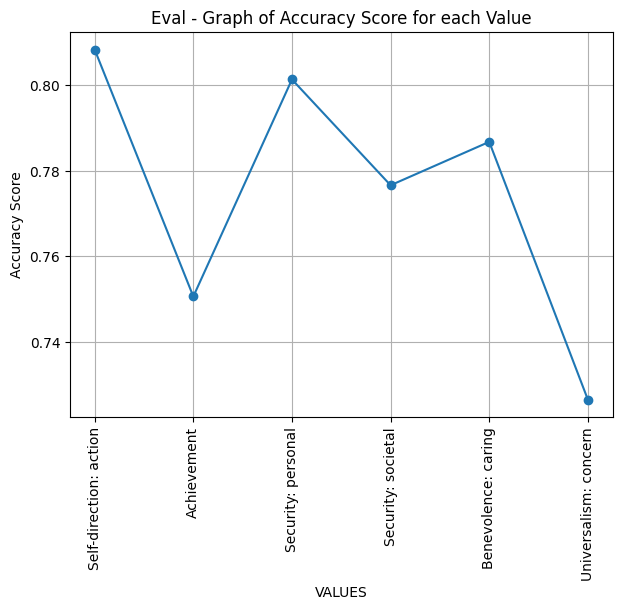

In [28]:
plt.figure(figsize=(7, 5))

plt.plot(list(acc.keys()), list(acc.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('Accuracy Score')
plt.title('Eval - Graph of Accuracy Score for each Value')

plt.grid(True)
plt.show()

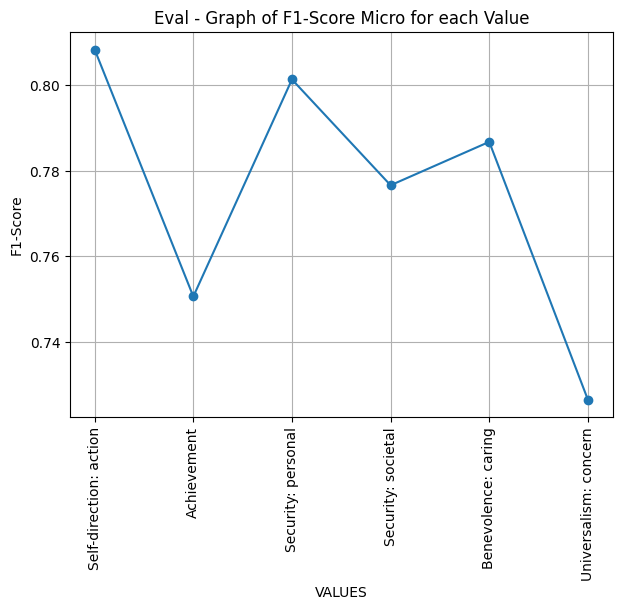

In [29]:
f1 = dict()
for i in range(n_labels):
  f1[value_col[i]] = metrics.f1_score(e_t[:, i], e_p[:, i], average='micro')

plt.figure(figsize=(7, 5))

plt.plot(list(f1.keys()), list(f1.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('F1-Score')
plt.title('Eval - Graph of F1-Score Micro for each Value')

plt.grid(True)
plt.show()

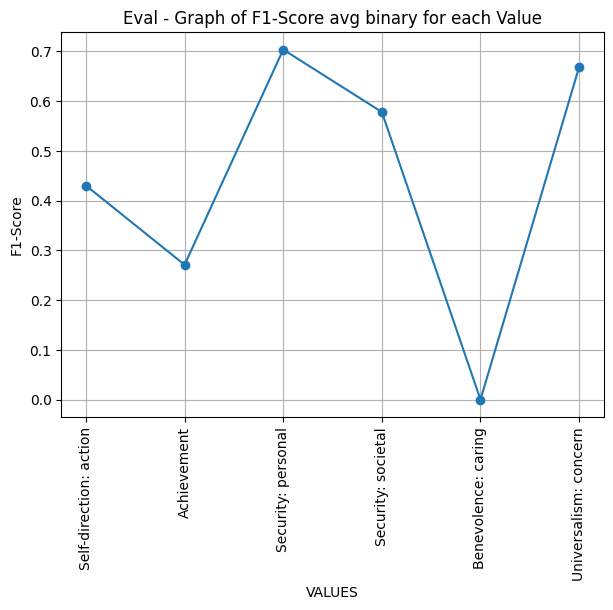

In [30]:
f1 = dict()
for i in range(n_labels):
  f1[value_col[i]] = metrics.f1_score(e_t[:, i], e_p[:, i], average='binary')

plt.figure(figsize=(7, 5))

plt.plot(list(f1.keys()), list(f1.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('F1-Score')
plt.title('Eval - Graph of F1-Score avg binary for each Value')

plt.grid(True)
plt.show()

In [31]:
acc_t = dict()

In [32]:
e_t_t = np.array(train_targets)
e_p_t = np.array(train_outputs)

In [33]:
for i in range(n_labels):
  acc_t[value_col[i]] = metrics.accuracy_score(e_t_t[:, i], e_p_t[:, i])

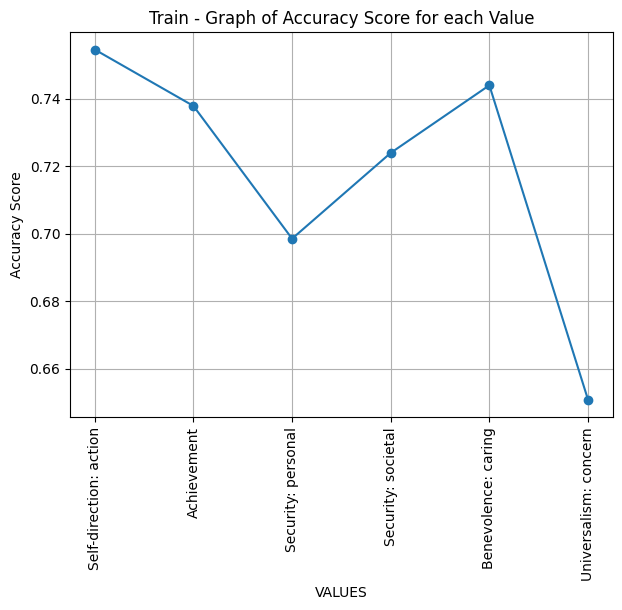

In [34]:
plt.figure(figsize=(7, 5))

plt.plot(list(acc_t.keys()), list(acc_t.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('Accuracy Score')
plt.title('Train - Graph of Accuracy Score for each Value')

plt.grid(True)
plt.show()